In [1]:
import tensorflow as tf
import numpy as np
import math
#%autoindent

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x
    
np.random.seed(0)

data = np.load('data_with_labels.npz')
#print('In the arhive included files: ', data.files)

train = data['arr_0']/255.
labels = data['arr_1']

# print('train[0]\n', train[0], train.shape[0])
# print('labels[0] = ', labels[0], len(labels))

import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline

def to_onehot(labels, nclasses=5):
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0]*0.1)# ~ 10% from all samples


test_idx, training_idx = indices[:valid_cnt],indices[valid_cnt:]
test, train = train[test_idx, :], train[training_idx, :]
onehot_test, onehot_train = onehot[test_idx,:],onehot[training_idx,:]

sess = tf.InteractiveSession()



In [2]:
x = tf.placeholder("float", [None, 36, 36])
x_im = tf.reshape(x, [-1, 36, 36, 1])
y_ = tf.placeholder("float", [None, 5])
num_filters = 4
winx = 5
winy = 5

W1 = tf.Variable(tf.truncated_normal([winx, winy, 1, num_filters],stddev=1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_filters]))

xw = tf.nn.conv2d(x_im, W1, strides=[1, 1, 1, 1], padding='SAME')
h1 = tf.nn.relu(xw + b1)

pl = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
pl_size = np.product([s.value for s in pl.get_shape()[1:]])
plf = tf.reshape(pl, [-1, pl_size])

num_hidden = 32
W2 = tf.Variable(tf.truncated_normal([pl_size, num_hidden], stddev=2./math.sqrt(pl_size)))
b2 = tf.Variable(tf.constant(0.2, shape=[num_hidden]))
h2 = tf.nn.relu(tf.matmul(plf,W2) + b2)

W3 = tf.Variable(tf.truncated_normal([num_hidden, 5], stddev=1.0/math.sqrt(num_hidden)))
b3 = tf.Variable(tf.constant(0.1, shape=[5]))

keep_prob = tf.placeholder("float")
h2_drop = tf.nn.dropout(h2, keep_prob)

In [4]:
import time, sys

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress, barLength=100):
     # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1.0
        status = "Done...\r\n"
    block = int(barLength*progress)
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + " "*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [8]:
sess.run(tf.initialize_all_variables())

y = tf.nn.softmax(tf.matmul(h2_drop,W3) + b3)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)) # Boolean is equl maxvalues in y and y_
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) # The mean across a converted to 0, 1 from boolean

epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)

saver = tf.train.Saver()


for i in tqdm(range(epochs)):
    if i % 10 == 0:
        A = accuracy.eval(feed_dict={x: train, y_: onehot_train, keep_prob: 1.0})
        train_acc[i//10] = A
        A = accuracy.eval(feed_dict={x:test, y_: onehot_test, keep_prob: 1.0})
        test_acc[i//10] = A
    if i%5 == 0:
        update_progress(1.*i/epochs, 100)
    train_step.run(feed_dict={x: train, y_:onehot_train, keep_prob: 0.5})
    if i%500 == 0:
        saver.save(sess, 'conv_tmp.ckpt')
print("")
print(train_acc[-1])
print(test_acc[-1])
plt.figure(figsize=(6,6))
plt.plot(train_acc, 'bo')
plt.plot(test_acc, 'rx')
plt.show()

ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)

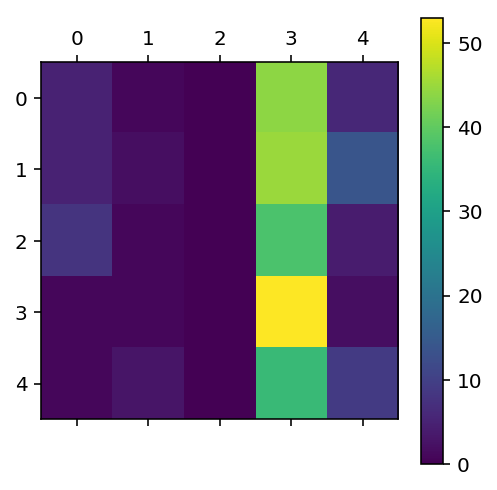

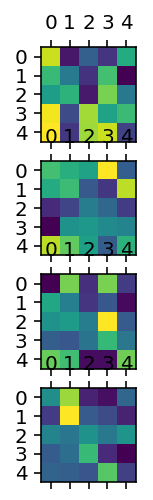

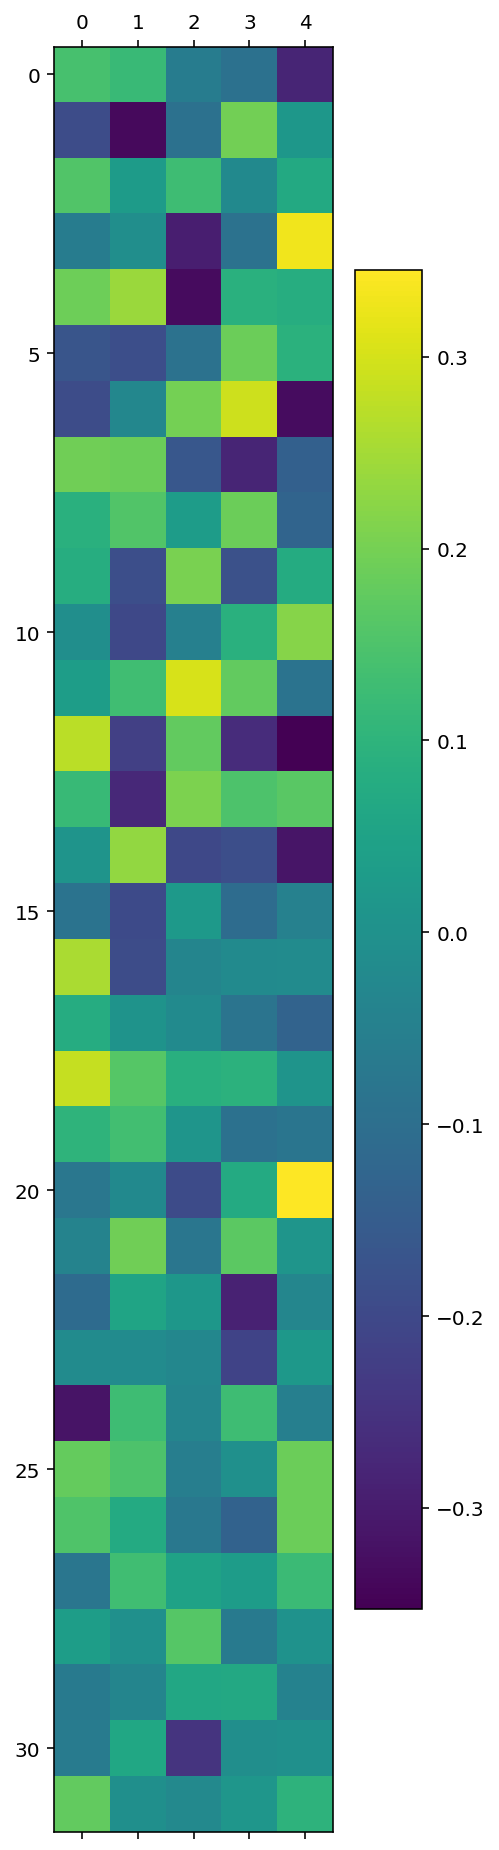

In [6]:
pred = np.argmax(y.eval(feed_dict={x: test, keep_prob: 1.0, y_: onehot_test}), axis=1)
conf = np.zeros([5, 5])

for p,t in zip(pred, np.argmax(onehot_test, axis=1)):
    conf[t,p] += 1
plt.matshow(conf)
plt.colorbar()
plt.show()

f, plts = plt.subplots(4)
for i in range(4):
    plts[i].matshow(W1.eval()[:,:,0,i])
plt.show()
plt.matshow(W3.eval())
plt.colorbar()
plt.show()

In [7]:
saver = tf.train.Saver()
saver.save(sess, "conv1.ckpt")

saver.restore(sess, "conv1.ckpt")

# Or use numpy manually
def save_all(name='conv1.npz'):
    np.savez_compressed(name, W1.eval(), b1.eval(), W2.eval(), b2.eval(), W3.eval(), b3.eval())

save_all()

def load_all(name='conv1.npz'):
    data = np.load(name)
    sess.run(W1.assign(data['arr_0']))
    sess.run(b1.assign(data['arr_1']))
    sess.run(W2.assign(data['arr_2']))
    sess.run(b2.assign(data['arr_3']))
    sess.run(W3.assign(data['arr_4']))
    sess.run(b3.assign(data['arr_5']))
    
load_all()

sess.close


ValueError: Parent directory of conv1.ckpt doesn't exist, can't save.